# Plot

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import sys
import random
sys.path.append('../')
from auxPlots import getInfo, getDistributions, getATLASdistributions

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

In [2]:
# files = list(glob.glob('../../pp2tt_NP/Events/run_03/events.lhe.gz'))
files = ['../../gg2tt_NP/Events/run_13/events.lhe.gz',
        #  '../../qq2tt_NP/Events/run_04/events.lhe.gz'
         ]
smFiles = ['../../gg2tt_LO/Events/run_01/unweighted_events.lhe.gz',
        #    '../../qq2tt_LO/Events/run_01/unweighted_events.lhe.gz'
           ]
bsmFiles = files[:]

In [3]:
# Get info
fileData = {f : getInfo(f) for f in smFiles+bsmFiles}
for f in smFiles:
    fileData[f]['model'] = 'SM'
for f in bsmFiles:
    fileData[f]['model'] = 'BSM'
# Set SM model by hand:

allModels = sorted(list(set([info['model'] for info in fileData.values()])))
allPars = sorted(list(set([info['(mST,mChi,mT,yDM)'] for info in fileData.values()])))
allProcesses = sorted(list(set([info['process'] for info in fileData.values()])))
print(allModels)
print(allPars)
print(allProcesses)

['BSM', 'SM']
[(500.0, 400.0, 172.0, 5.0), (500.0, 400.0, 172.0, 20.0)]
['$g g \\to \\bar{t} t$', '$p p \\to \\bar{t} t$']


In [4]:
# # Select files:
# models = ['SM','1-loop', 'EFT']
# pars = [(500.,400.,172.5,1.0)]
# procs = allProcesses[:]

# bsmFiles = files[:]
# smFiles = []
# for f,fInfo in fileData.items():
#     if fInfo['model'] not in models:
#         continue
#     if fInfo['process'] not in procs:
#         continue
        
#     if fInfo['model'] == 'SM':
#         smFiles.append(f)
#     else:
#         if fInfo['(mST,mChi,mT,yDM)'] not in pars:
#             continue
#         bsmFiles.append(f)
    
# print(bsmFiles)
# print(smFiles)
# Sort files so largest cross-sections come first
bsmFiles = sorted(bsmFiles, key = lambda f: (fileData[f]['process'],fileData[f]['model']), reverse=True)
smFiles = sorted(smFiles, key = lambda f: fileData[f]['process'], reverse=True)
selectedFiles = smFiles+bsmFiles

In [5]:
print(len(selectedFiles))
for f in selectedFiles:
    print(f)

2
../../gg2tt_LO/Events/run_01/unweighted_events.lhe.gz
../../gg2tt_NP/Events/run_13/events.lhe.gz


### Get distributions without cuts

In [6]:

dists = {f : getDistributions(f) for f in selectedFiles}
# Randomly choose one of the momenta to use as the hadronic top pT
for f in dists:
    dists[f]['pTh'] = []
    for i,pt1 in enumerate(dists[f]['pT1']):
        pt2 =dists[f]['pT2'][i]
        dists[f]['pTh'].append(random.choice([pt1,pt2]))

In [7]:
for f,res in dists.items():    
    print('\n %s : %s' %(fileData[f]['model'],fileData[f]['process']))
    print('total xsec    = ',sum(res['weights']))
    print('MC events     = ',res['nevents'])


 SM : $g g \to \bar{t} t$
total xsec    =  453.314739612061
MC events     =  150000

 BSM : $p p \to \bar{t} t$
total xsec    =  404.8410958914458
MC events     =  50000


In [8]:
# Define colors
colors = {f : sns.color_palette('Paired')[i+1] for i,f in enumerate(dists.keys())}

### Plot invariant mass

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


diff 10.7754945182078 194.01575878769347 $p p \to \bar{t} t$ (BSM) $g g \to \bar{t} t$ (SM)


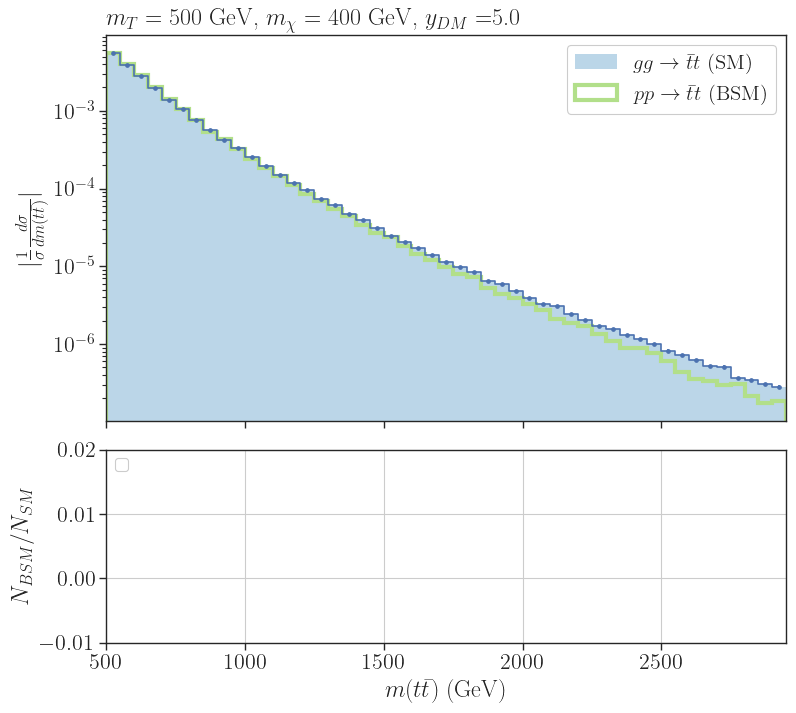

In [11]:
# Define scale factor (new yDM value)
kscales = {f : 1.0 for f in smFiles} # The factor of 2 is to account for the 2 possible ttbar decays: (t -> jj, tbar->l nu) + (t -> l nu, tbar->jj)
yDM = 5.0
kscales.update({f : 1.0*(yDM/fileData[f]['(mST,mChi,mT,yDM)'][-1])**2 for f in bsmFiles})

_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)
bins = np.arange(500.,3000.,50.)

labels = []
pmodels = []
hists = []
histsErr = []
c = []
ks = []
for f in dists:
    process = fileData[f]['process']
    model = fileData[f]['model']
    mST,mChi,mT,_ = fileData[f]['(mST,mChi,mT,yDM)']
    
    kscale = kscales[f]
    pmodels.append(r'%s (%s)' %(process,model))
    label = pmodels[-1]
    labels.append(label)
    c.append(colors[f])
    ks.append(kscale)
    h,_ = np.histogram(dists[f]['mTT'],bins=bins,weights=kscale*dists[f]['weights'])
    hists.append(h)
    #Compute MC error
    hErr,_ = np.histogram(dists[f]['mTT'],bins=bins,weights=(kscale*dists[f]['weights'])**2)
    hErr = np.sqrt(hErr)    
    histsErr.append(hErr)
    

histsSM = [h for i,h in enumerate(hists) if 'SM' in labels[i] and ('BSM' not in labels[i])]    
histsErrSM = [h for i,h in enumerate(histsErr) if 'SM' in labels[i] and ('BSM' not in labels[i])]
labelsSM = [l for i,l in enumerate(labels) if 'SM' in labels[i] and ('BSM' not in labels[i])]    
cSM =  [cc for i,cc in enumerate(c) if 'SM' in labels[i] and ('BSM' not in labels[i])]    
axarr[0].hist([bins[:-1]]*len(histsSM),label=labelsSM,bins=bins,
                          weights=histsSM,alpha=0.3,density=True,
                          linewidth=0,color=cSM,stacked=True)

hSM = sum([hh for hh in histsSM[:]])
hErrSM = np.sqrt(sum([hh**2 for hh in histsErrSM[:]]))
bin_centers = (bins[1:]+bins[0:-1])/2.0
axarr[0].errorbar(bin_centers,hSM/(sum(hSM)*(bins[1]-bins[0])), 
                  yerr =hErrSM/(sum(hSM)*(bins[1]-bins[0])), marker = '.',  drawstyle = 'steps-mid')

labelsTrack = []
for i,h in enumerate(hists):
    if 'SM' in labels[i] and ('BSM' not in labels[i]):
        continue 
    hdiff = None
    for j,hh in enumerate(histsSM):
        if hdiff is None or abs(sum(h-hh)) < abs(sum(hdiff)): # Subtract SM histogram with total xsec closest to the SM+BSM one 
            print('diff',sum(h),sum(hh),labels[i],labels[j])
            hdiff = h-hh
    hdiff = h
    axarr[0].hist(bins[:-1],weights=np.abs(hdiff),label=labels[i],bins=bins,
                  color=c[i],alpha=1.0,histtype='step',density=True,
                  linewidth=3,fill=False,zorder=i,linestyle='solid')
    # axarr[0].errorbar(bin_centers,h/(sum(h)*(bins[1]-bins[0])),
                    #   yerr =histsErr[i]/(sum(h)*(bins[1]-bins[0])),label=labels[i],
                    #   marker = '.',  drawstyle = 'steps-mid',
                #   color=c[i],alpha=1.0,
                #   linewidth=3,zorder=i)

# # Ratio plot:
# hLoop = sum([h for i,h in enumerate(hists) if '1-loop' in labels[i]])
# hEFT = sum([h for i,h in enumerate(hists) if 'EFT' in labels[i]])
# labels.append(r'$p p \to \bar{t} t$ (1-loop)')
# labels.append(r'$p p \to \bar{t} t$ (EFT)')
# c.append('black')
# c.append('gray')
# for i,h in enumerate(hists+[hLoop,hEFT]):
#     if 'SM' in labels[i]:
#         continue
#     if (not 'loop' in labels[i]) and (not 'p p ' in labels[i]):
#         continue
#     # Compute ratio (keeping negative and positive values)
#     ratio = np.divide(h, hSM, out=np.zeros_like(h),where=hSM != 0)
#     # Remove zero values
#     nonzero = np.where((np.sign(ratio) != 0))
#     x = (bins[:-1]+bins[1:])/2.0
#     y = ratio
#     label = labels[i]
#     axarr[1].plot(x,y,linewidth=3.0,linestyle='solid',alpha=0.8,
#                           label=label,c=c[i])
        
axarr[0].set_yscale('log')
# axarr[0].set_ylim(1e-4,500)
# axarr[0].set_xticks(np.arange(0.,bins.max(),500))
axarr[0].set_xlim(bins.min(),bins.max())
axarr[1].set_xlabel(r'$m(t\bar{t})$ (GeV)')
axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
axarr[1].set_ylabel(r'$N_{BSM}/N_{SM}$')
axarr[1].set_ylim(-0.01,0.02)
axarr[1].set_yticks(np.arange(-0.01,0.03,0.01))
axarr[1].legend(loc='upper left',fontsize=12,framealpha=1.0,ncol=2)
axarr[1].grid()


axarr[0].legend(framealpha=1.0,loc='upper right',fontsize=15)
# axarr[1].legend(framealpha=1.0,loc='upper left')
axarr[0].set_title(r'$m_{T} = %1.0f$ GeV, $m_{\chi} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mST,mChi,yDM),
                   loc='left')
plt.savefig('mtt_mST%i_mChi%i_yDM_%i.png' %(int(mST),int(mChi),int(yDM)))
plt.show()

In [10]:
kscales

{'../../gg2tt_LO/Events/run_01/unweighted_events.lhe.gz': 1.0,
 '../../gg2tt_NP/Events/run_13/events.lhe.gz': 0.0625}